In [1]:
import argparse
import os
import json
import logging
import string
import collections

import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

if os.getcwd().endswith('notebook'):
    os.chdir('..')

from rna_learn.alphabet import CODON_REDUNDANCY
from rna_learn.codon_bias.trna_ai import compute_trna_ai_weights
from rna_learn.codon_bias.graph import load_codon_bias
from rna_learn.codon_bias.distance import compute_codon_bias_distance

In [2]:
sns.set(palette='colorblind', font_scale=1.3)
palette = sns.color_palette()
logging.basicConfig(level=logging.INFO, format="%(asctime)s (%(levelname)s) %(message)s")
logger = logging.getLogger(__name__)

In [3]:
db_path = os.path.join(os.getcwd(), 'data/db/seq.db')
engine = create_engine(f'sqlite+pysqlite:///{db_path}')

In [4]:
codon_to_aa_table = { 
    'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M', 
    'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T', 
    'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K', 
    'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',                  
    'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L', 
    'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P', 
    'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q', 
    'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R', 
    'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V', 
    'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A', 
    'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E', 
    'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G', 
    'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S', 
    'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L', 
    'TAC':'Y', 'TAT':'Y', 'TAA':'*', 'TAG':'*', 
    'TGC':'C', 'TGT':'C', 'TGA':'*', 'TGG':'W', 
}

In [5]:
aa_to_codons = collections.defaultdict(list)
for codon, aa in codon_to_aa_table.items():
    aa_to_codons[aa].append(codon)
aa_to_codons = dict(aa_to_codons)
aa_to_codons

{'I': ['ATA', 'ATC', 'ATT'],
 'M': ['ATG'],
 'T': ['ACA', 'ACC', 'ACG', 'ACT'],
 'N': ['AAC', 'AAT'],
 'K': ['AAA', 'AAG'],
 'S': ['AGC', 'AGT', 'TCA', 'TCC', 'TCG', 'TCT'],
 'R': ['AGA', 'AGG', 'CGA', 'CGC', 'CGG', 'CGT'],
 'L': ['CTA', 'CTC', 'CTG', 'CTT', 'TTA', 'TTG'],
 'P': ['CCA', 'CCC', 'CCG', 'CCT'],
 'H': ['CAC', 'CAT'],
 'Q': ['CAA', 'CAG'],
 'V': ['GTA', 'GTC', 'GTG', 'GTT'],
 'A': ['GCA', 'GCC', 'GCG', 'GCT'],
 'D': ['GAC', 'GAT'],
 'E': ['GAA', 'GAG'],
 'G': ['GGA', 'GGC', 'GGG', 'GGT'],
 'F': ['TTC', 'TTT'],
 'Y': ['TAC', 'TAT'],
 '*': ['TAA', 'TAG', 'TGA'],
 'C': ['TGC', 'TGT'],
 'W': ['TGG']}

## Load graph

In [6]:
%%time
graph_path = os.path.join(os.getcwd(), 'data/codon_bias_graph.gpickle')
graph = nx.read_gpickle(graph_path)

CPU times: user 335 ms, sys: 50.1 ms, total: 385 ms
Wall time: 387 ms


In [7]:
nx.number_connected_components(graph)

8

In [8]:
len(nx.node_connected_component(graph, 2336))

2672

## Load species Ids

In [9]:
species_query = """
select species_taxid, species, phylum, superkingdom, growth_tmp from species_traits
"""
species_df = pd.read_sql(species_query, engine)
species_taxids = species_df['species_taxid'].values

In [10]:
species_df[species_df['growth_tmp'] < 20]

,species_taxid,species,phylum,superkingdom,growth_tmp
6,25,Shewanella hanedai,Proteobacteria,Bacteria,16.0
20,102,Polaribacter glomeratus,Bacteroidetes,Bacteria,15.0
141,531,Polaribacter irgensii,Bacteroidetes,Bacteria,4.0
184,659,Photobacterium phosphoreum,Proteobacteria,Bacteria,19.5
194,688,Aliivibrio logei,Proteobacteria,Bacteria,16.0
...,...,...,...,...,...
2548,1217908,Octadecabacter antarcticus,Proteobacteria,Bacteria,4.0
2621,1424659,Cryobacterium flavum,Actinobacteria,Bacteria,10.0
2622,1424661,Cryobacterium luteum,Actinobacteria,Bacteria,10.0
2667,1706046,Sulfurirhabdus autotrophica,Proteobacteria,Bacteria,15.0


## Nearby metrics

In [11]:
def compute_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))


def predict_numerical_field_from_neighbours(graph, species_taxid, trait, control_for_phylum=True):
    current_node = graph.nodes[species_taxid]
    
    if pd.isnull(current_node[trait]):
        return None, None, None
    
    current_phylum = current_node['phylum']
    values = []
    for key in graph.neighbors(species_taxid):
        node = graph.nodes[key]
        
        if pd.isnull(node[trait]):
            continue
        
        if control_for_phylum and node['phylum'] != current_phylum:
            v = node[trait]
            values.append(v)
        elif not control_for_phylum:
            v = node[trait]
            values.append(v)
            
    if len(values) == 0:
        prediction = None
    else:
        prediction = np.mean(values)

    return current_node[trait], prediction, values

def compute_mae_from_neighbour_predictions(graph, species_taxids, trait, control_for_phylum=True):
    actuals = []
    predictions = []
    for i, species_taxid in enumerate(species_taxids):
        actual, prediction, _ = predict_numerical_field_from_neighbours(
            graph, 
            species_taxid, 
            trait, 
            control_for_phylum,
        )
        
        if actual is None or prediction is None:
            continue
        
        actuals.append(actual)
        predictions.append(prediction)
        
    return compute_mae(np.array(actuals), np.array(predictions))

In [12]:
def compute_accuracy(y_true, y_pred):
    correct = [
        1 if y_true[i] == y_pred[i] else 0
        for i in range(len(y_pred))
    ]
    return 100 * np.sum(correct) / len(y_pred)


def predict_categorical_field_from_neighbours(graph, species_taxid, trait, control_for_phylum=True):
    current_node = graph.nodes[species_taxid]
    
    if pd.isnull(current_node[trait]):
        return None, None, None
    
    current_phylum = current_node['phylum']
    values = collections.defaultdict(int)
    for key in graph.neighbors(species_taxid):
        node = graph.nodes[key]
        
        if pd.isnull(node[trait]):
            continue
        
        if control_for_phylum and node['phylum'] != current_phylum:
            v = node[trait]
            values[v] += 1
        elif not control_for_phylum:
            v = node[trait]
            values[v] += 1
            
    if len(values) == 0:
        prediction = None
        sorted_values = []
    else:
        sorted_values = sorted(values.items(), key=lambda t: t[1], reverse=True)
        prediction = sorted_values[0][0]

    return current_node[trait], prediction, sorted_values

def compute_accuracy_from_neighbour_predictions(graph, species_taxids, trait, control_for_phylum=True):
    actuals = []
    predictions = []
    for i, species_taxid in enumerate(species_taxids):
        actual, prediction, _ = predict_categorical_field_from_neighbours(
            graph, 
            species_taxid, 
            trait, 
            control_for_phylum,
        )
        
        if actual is None or prediction is None:
            continue
        
        actuals.append(actual)
        predictions.append(prediction)
        
    return compute_accuracy(actuals, predictions)

In [13]:
compute_mae_from_neighbour_predictions(graph, species_taxids, 'growth_tmp')

8.644639843926784

In [14]:
compute_mae_from_neighbour_predictions(graph, species_taxids, 'growth_tmp', control_for_phylum=False)

6.363267744129107

In [15]:
compute_mae_from_neighbour_predictions(graph, species_taxids, 'optimum_ph')

0.8045548369656437

In [16]:
compute_mae_from_neighbour_predictions(graph, species_taxids, 'gc_content')

1.5698871501477607

In [17]:
compute_mae_from_neighbour_predictions(graph, species_taxids, 'tRNA_genes')

14.398689358230122

In [18]:
compute_mae_from_neighbour_predictions(graph, species_taxids, 'rRNA16S_genes')

2.167322515728827

In [19]:
compute_mae_from_neighbour_predictions(graph, species_taxids, 'coding_genes')

1183.0628712801658

In [20]:
actual, prediction, values = predict_numerical_field_from_neighbours(graph, 2336, 'growth_tmp')
print(actual, prediction, np.std(values))
values

80.0 78.725 1.2749999999999986


[77.45, 80.0]

In [21]:
compute_accuracy_from_neighbour_predictions(graph, species_taxids, 'isolation_source')

14.698162729658792

In [22]:
for key in graph.neighbors(2336):
    node = graph.nodes[key]
    print(
        node['species_taxid'], 
        node['species'], 
        node['superkingdom'], 
        node['phylum'], 
        node['growth_tmp'],
        node['isolation_source'],
    )

2337 Thermotoga neapolitana Bacteria Thermotogae 79.0 sediment_marine_hydrothermal
57487 Pseudothermotoga hypogea Bacteria Thermotogae 69.95 petroleum
58290 Archaeoglobus veneficus Archaea Euryarchaeota 77.45 sediment_marine_hydrothermal
93929 Thermotoga petrophila Bacteria Thermotogae 77.25 wastewater
93930 Thermotoga naphthophila Bacteria Thermotogae 77.15 wastewater
565033 Geoglobus acetivorans Archaea Euryarchaeota 80.0 sediment_marine_hydrothermal
1184387 Mesotoga prima Bacteria Thermotogae 37.0 sediment_marine
1236046 Mesotoga infera Bacteria Thermotogae 45.0 water_marine


In [23]:
graph.nodes[2336]

{'species_taxid': 2336,
 'species': 'Thermotoga maritima',
 'growth_tmp': 80.0,
 'genus': 'Thermotoga',
 'family': 'Thermotogaceae',
 'order': 'Thermotogales',
 'class': 'Thermotogae',
 'phylum': 'Thermotogae',
 'superkingdom': 'Bacteria',
 'optimum_ph': nan,
 'gram_stain': 'negative',
 'metabolism': 'anaerobic',
 'sporulation': 'no',
 'motility': 'yes',
 'range_salinity': None,
 'cell_shape': 'bacillus',
 'isolation_source': 'sediment_marine_hydrothermal',
 'doubling_h': 1.233,
 'genome_size': 1865969.5,
 'gc_content': 46.214,
 'coding_genes': 1871.167,
 'tRNA_genes': 46.0,
 'rRNA16S_genes': 1.0,
 'n_assemblies': 6,
 'assembly_accessions': ('GCA_000008545.1',
  'GCA_000230655.3',
  'GCA_000390265.1',
  'GCA_000978535.1',
  'GCA_000978555.1',
  'GCA_000978575.1')}

In [24]:
graph.nodes[565033]

{'species_taxid': 565033,
 'species': 'Geoglobus acetivorans',
 'growth_tmp': 80.0,
 'genus': 'Geoglobus',
 'family': 'Archaeoglobaceae',
 'order': 'Archaeoglobales',
 'class': 'Archaeoglobi',
 'phylum': 'Euryarchaeota',
 'superkingdom': 'Archaea',
 'optimum_ph': nan,
 'gram_stain': None,
 'metabolism': 'anaerobic',
 'sporulation': None,
 'motility': 'yes',
 'range_salinity': None,
 'cell_shape': None,
 'isolation_source': 'sediment_marine_hydrothermal',
 'doubling_h': nan,
 'genome_size': 1860816.25,
 'gc_content': 46.8,
 'coding_genes': 2172.667,
 'tRNA_genes': 48.0,
 'rRNA16S_genes': 1.0,
 'n_assemblies': 1,
 'assembly_accessions': ('GCA_000789255.1',)}

In [25]:
graph.nodes[58290]

{'species_taxid': 58290,
 'species': 'Archaeoglobus veneficus',
 'growth_tmp': 77.45,
 'genus': 'Archaeoglobus',
 'family': 'Archaeoglobaceae',
 'order': 'Archaeoglobales',
 'class': 'Archaeoglobi',
 'phylum': 'Euryarchaeota',
 'superkingdom': 'Archaea',
 'optimum_ph': nan,
 'gram_stain': 'negative',
 'metabolism': 'anaerobic',
 'sporulation': None,
 'motility': 'yes',
 'range_salinity': None,
 'cell_shape': 'coccus',
 'isolation_source': 'sediment_marine_hydrothermal',
 'doubling_h': 1.02,
 'genome_size': 1901942.4,
 'gc_content': 47.0,
 'coding_genes': 2076.0,
 'tRNA_genes': 46.0,
 'rRNA16S_genes': 1.0,
 'n_assemblies': 1,
 'assembly_accessions': ('GCA_000194625.1',)}

In [26]:
predict_categorical_field_from_neighbours(graph, 2336, 'isolation_source')

('sediment_marine_hydrothermal',
 'sediment_marine_hydrothermal',
 [('sediment_marine_hydrothermal', 2)])

## Term frequency: find proteins with codon bias near the mean

In [27]:
def protein_description_word_count(assembly_accession, below_threshold=True, count_type='document'):
    if count_type not in ('document', 'term'):
        raise ValueError('count type should be one of document or term')
        
    cds_codon_bias_folder = os.path.join(os.getcwd(), 'data/cds_codon_bias')
    if below_threshold:
        cds_codon_bias_folder = os.path.join(cds_codon_bias_folder, 'below_threshold')
    else:
        cds_codon_bias_folder = os.path.join(cds_codon_bias_folder, 'all')
        
    cds_codon_bias_path = os.path.join(cds_codon_bias_folder, f'{assembly_accession}_codon_bias.csv')
    
    black_list = [
        '',
        'protein',
        'enzyme',
        'subunit',
        'domain',
        'domain-containing',
        'hypothetical',
        'putative',
        'probable',
        'conserved',
        'factor',
        'large',
        'small',
        'family',
        'superfamily',
        'outer',
        'cell',
        'i',
        'ii',
        'iii',
        'iv',
        'v',
        'vi',
        'alpha',
        'beta',
        'gamma',
        'type',
        'and',
        'or',
        'of',
        'class',
        'assembly',
        'acid',
        'component',
        'response',
        '2x',
        '1-2',
    ]
    black_list += [c for c in string.ascii_lowercase]
    black_list += [c for c in string.digits]
    black_list = set(black_list)
    
    df = pd.read_csv(cds_codon_bias_path)
    descriptions = df['description'].values
    
    counts = collections.defaultdict(int)
    for description in descriptions:
        desc = str(description).replace(',', '').replace('.', '').replace('(', '').replace(')', '').strip()
        parts_1 = desc.split(' ')
        parts = []
        for p in parts_1:
            parts  += [v.lower() for v in p.split('/')]
            
        for word in parts:
            if word in black_list:
                continue
                
            if count_type == 'document':
                counts[word] = 1
            else:
                counts[word] += 1
    
    return dict(counts)


def compute_word_count(assembly_accessions, below_threshold=True, count_type='document', sorted_output=True):
    if count_type not in ('document', 'term'):
        raise ValueError('count type should be one of document or term')
    
    total_counts = {}
    for i, assembly_accession in enumerate(assembly_accessions):
        if (i+1) % 200 == 0:
            print(f'{i+1} / {len(assembly_accessions)}')
            
        counts = protein_description_word_count(assembly_accession, below_threshold, count_type)
        
        for k, v in counts.items():
            total_counts[k] = total_counts.get(k, 0) + counts[k]
    
    if sorted_output:
        word_counts = [
            (
                k, 
                np.round(100 * v / len(assembly_accessions), 2)
            ) 

            for k, v in total_counts.items()
        ]

        return sorted(word_counts, key=lambda t: t[1], reverse=True)
    else:
        return total_counts

In [28]:
def compute_word_scores(assembly_accessions, min_term_freq=1):
    top_term_freq = compute_word_count(
        assembly_accessions,
        below_threshold=True,
        count_type='term',
        sorted_output=False,
    )
    all_term_freqs = compute_word_count(
        assembly_accessions,
        below_threshold=False,
        count_type='term',
        sorted_output=False,
    )
    all_words = sorted(all_term_freqs.keys())
    
    word_scores = []
    for word in all_words:
        term_freq = top_term_freq.get(word, 0)
        all_term_freq = all_term_freqs[word]
        
        term_freq_norm = term_freq / len(assembly_accessions)
        all_term_freq_norm = all_term_freq / len(assembly_accessions)
        
        if term_freq_norm < min_term_freq:
            continue
            
        score = term_freq / all_term_freqs[word]
        
        word_scores.append((
            word, 
            score, 
            np.round(term_freq_norm, 2), 
            np.round(all_term_freq_norm, 2),
        ))
        
    return sorted(word_scores, key=lambda t: t[1], reverse=True)

In [29]:
def local_word_scores(graph, species_taxid, control_for_phylum=True, include_neighbours=True):
    current_node = graph.nodes[species_taxid]

    current_word_scores = compute_word_scores(current_node['assembly_accessions'])

    score_dicts = [{t[0]: t for t in current_word_scores}]
    word_set = set([t[0] for t in current_word_scores])
    
    neighbours = list(graph.neighbors(species_taxid))
    
    if include_neighbours:
        for key in neighbours:
            node = graph.nodes[key]

            if control_for_phylum and node['phylum'] == current_node['phylum']:
                continue

            word_scores = compute_word_scores(node['assembly_accessions'])

            word_set &= set([t[0] for t in word_scores])
            score_dicts.append({t[0]: t for t in word_scores})

    final_word_scores = []
    for word in sorted(word_set):
        scores, term_freqs, all_term_freqs = [], [], []
        for score_dict in score_dicts:
            _, score, term_freq, all_term_freq = score_dict[word]
            scores.append(score)
            term_freqs.append(term_freq)
            all_term_freqs.append(all_term_freq)
            
        final_word_scores.append((
            word, 
            np.round(np.mean(score), 3),
            np.round(np.mean(term_freqs), 2), 
            np.round(np.mean(all_term_freqs), 2),
        ))
        
    return sorted(final_word_scores, key=lambda t: t[1], reverse=True)

In [30]:
def retrieve_orginal_proteins(graph, species_taxid, include_neighbours=True):
    cds_codon_bias_folder = os.path.join(os.getcwd(), 'data/cds_codon_bias/below_threshold')
    
    species_taxids = [species_taxid] 
    if include_neighbours:
        species_taxids += [key for key in graph.neighbors(species_taxid)]
    
    word_scores = local_word_scores(graph, species_taxid, include_neighbours=include_neighbours)
    words = [t[0] for t in word_scores]
        
    protein_dict = collections.defaultdict(list)
    for species_taxid in species_taxids:
        node = graph.nodes[species_taxid]
        assembly_accessions = node['assembly_accessions']
        
        for assembly_accession in assembly_accessions:
            cds_codon_bias_path = os.path.join(cds_codon_bias_folder, f'{assembly_accession}_codon_bias.csv')
            df = pd.read_csv(cds_codon_bias_path)
            descriptions = df['description'].values
            distances = df['distance'].values
            
            for word in words:
                for i, protein_description in enumerate(descriptions):
                    protein_desc = str(protein_description)
                    protein_desc_key = protein_desc.replace(',', '').replace(': ', ' ').replace(':', ' ').lower()
                    if word.lower() in protein_desc_key:
                        protein_dict[protein_desc_key].append((protein_desc, distances[i]))
                        
    output_proteins = [
        (protein_dict[protein_desc][0][0], np.mean([t[1] for t in protein_dict[protein_desc]]))
        for protein_desc in protein_dict.keys()
    ]
                        
    return sorted(output_proteins, key=lambda t: t[1])


def retrieve_orginal_proteins_global(graph, species_taxids):
    cds_codon_bias_folder = os.path.join(os.getcwd(), 'data/cds_codon_bias/below_threshold')

    protein_dict = collections.defaultdict(list)
    seen_species = set()
    for s_ix, species_taxid in enumerate(species_taxids):
        if (s_ix + 1) % 10 == 0:
            print(f'{s_ix + 1:,} / {len(species_taxids):,}')
        
        if species_taxid in seen_species:
            continue
        
        node = graph.nodes[species_taxid]
        assembly_accessions = node['assembly_accessions']
        
        neighbors = list(graph.neighbors(species_taxid))
        
        seen_species.add(species_taxid)
        seen_species |= set(neighbors)
        
        word_scores = local_word_scores(graph, species_taxid)
        words = [t[0] for t in word_scores]
        
        for assembly_accession in assembly_accessions:
            cds_codon_bias_path = os.path.join(cds_codon_bias_folder, f'{assembly_accession}_codon_bias.csv')
            df = pd.read_csv(cds_codon_bias_path)
            descriptions = df['description'].values
            distances = df['distance'].values
            
            for word in words:
                for i, protein_description in enumerate(descriptions):
                    protein_desc = str(protein_description)
                    protein_desc_key = protein_desc.replace(',', '').replace(': ', ' ').replace(':', ' ').lower()
                    if word.lower() in protein_desc_key:
                        protein_dict[protein_desc_key].append((protein_desc, distances[i]))
                        
    output_proteins = [
        (protein_dict[protein_desc][0][0], np.mean([t[1] for t in protein_dict[protein_desc]]))
        for protein_desc in protein_dict.keys()
    ]
                        
    return sorted(output_proteins, key=lambda t: t[1])

In [31]:
original_proteins_2336 = retrieve_orginal_proteins(
    graph,
    species_taxid=2336,
    include_neighbours=False,
)
print(f'{len(original_proteins_2336):,} proteins')

for p in [t[0] for t in original_proteins_2336]:
    print(p)

134 proteins
permease
DNA-directed RNA polymerase subunit beta
alpha-mannosidase-related protein
alpha-mannosidase
alpha-mannosidase, putative
DNA-directed RNA polymerase, beta subunit
sensor histidine kinase
histidine kinase
DNA polymerase I
DNA-directed DNA polymerase I
DNA polymerase
Xylose-regulated ABC transporter, substrate-binding component
oligopeptide ABC transporter, periplasmic oligopeptide-binding protein
iron transporter FeoB
DNA gyrase, subunit A
pyrimidine-nucleoside phosphorylase
thymidine phosphorylase
UDP-N-acetylglucosamine 2-epimerase
Flagellar hook protein FlgE
flagellar hook-basal body protein
helicase
single stranded DNA-specific exonuclease, putative
single-stranded DNA exonuclease
Single-stranded-DNA-specific exonuclease RecJ
Superfamily II DNA/RNA helicase, SNF2 family
CRISPR-associated protein
DNA mismatch repair protein
DNA mismatch repair protein MutS
DNA ligase
NAD-dependent DNA ligase LigA
CRISPR-associated helicase Cas3
double-stranded DNA repair protein

In [32]:
#for v in [t[0] for t in original_proteins_2336 if t[1] < 0.1][:51]:
#    print(v)

In [33]:
original_proteins_562 = retrieve_orginal_proteins(
    graph,
    species_taxid=562,
    include_neighbours=False,
)
print(f'{len(original_proteins_562):,} proteins')
for p in [t[0] for t in original_proteins_562]:
    print(p)

164 proteins
aconitate hydratase 1
alpha2-macroglobulin
exodeoxyribonuclease V subunit RecB
bacteriophage N4 receptor, outer membrane protein
putative outer membrane protein, N-terminal fragment
ribonucleoside-diphosphate reductase 2 subunit alpha
apo-serine activating enzyme
alpha-mannosidase
peptidase M16 family protein
inner membrane protein - inhibits the Rcs signaling pathway
biotin sulfoxide reductase
putative selenate reductase YnfE
multidrug efflux pump RND permease AcrF
DUF5107 domain-containing protein YphG
3-hydroxyacyl-CoA dehydrogenase FadJ
peptidoglycan DD-transpeptidase FtsI
transcription-repair coupling factor
protein-tyrosine kinase Etk
putative selenate reductase YnfF
putative TonB-dependent outer membrane receptor
exodeoxyribonuclease V subunit RecC
putative xanthine dehydrogenase molybdenum-binding subunit XdhA
fused DNA-binding transcriptional repressor/proline dehydrogenase/1-pyrroline-5-carboxylate dehydrogenase PutA
DNA mismatch repair protein MutS
ATP dependent

In [34]:
original_proteins_531 = retrieve_orginal_proteins(
    graph,
    species_taxid=531,
    include_neighbours=False,
)
print(f'{len(original_proteins_531):,} proteins')
for p in [t[0] for t in original_proteins_531]:
    print(p)

79 proteins
FAD linked oxidase-like protein
Large subunit of NADH-dependent glutamate synthase
HAE1 efflux family protein
oxidoreductase alpha (molybdopterin) subunit
ATP-dependent DNA helicase
DNA polymerase I
glycine dehydrogenase
probable glycosyl hydrolase
probable periplasmic tail-specific proteinase
bifunctional GMP synthase/glutamine amidotransferase protein
putative DNA polymerase III alpha subunit
ATP-dependent Clp protease, ATP-binding subunit ClpC
phosphoribosylformylglycinamidine synthase
DNA mismatch repair protein
isoleucyl-tRNA synthetase
TonB-dependent siderophore receptor
putative NADP-dependent malic enzyme
probable long chain fatty-acid CoA ligase
glutamine synthetase
AcrB/AcrD family multidrug resistance protein
putative chloride channel protein
DNA topoisomerase IV subunit A
methionyl-tRNA synthetase
putative protease
ATP-dependent helicase
sensory transduction histidine kinase
acetoin dehydrogenase (TPP-dependent) beta chain
aminoacyl-histidine dipeptidase
FixL-re

## tRNA expression

In [35]:
species_codon_ratios_path = os.path.join(os.getcwd(), 'data/species_codon_ratios.csv')
species_codon_df = load_codon_bias(engine, species_codon_ratios_path).set_index('species_taxid')
species_codon_df.head()

,in_test_set,AAA_ratio,AAG_ratio,AAT_ratio,AAC_ratio,ACT_ratio,ACC_ratio,ACA_ratio,ACG_ratio,CGT_ratio,...,motility,range_salinity,cell_shape,isolation_source,doubling_h,genome_size,gc_content,coding_genes,tRNA_genes,rRNA16S_genes
species_taxid,,,,,,,,,,,,,,,,,,,,,
7,True,0.082550,0.917450,0.327724,0.672276,0.024511,0.575353,0.036262,0.363875,0.078732,...,yes,None,None,host_plant,NaN,5369771.500,67.300,4713.667,53.000,3.0
9,False,0.919627,0.080373,0.858168,0.141832,0.454569,0.050026,0.446018,0.049387,0.325065,...,yes,None,coccobacillus,host_animal_ectotherm,35.40,601699.243,25.469,517.549,30.485,1.0
11,True,0.007302,0.992698,0.010730,0.989270,0.008586,0.425527,0.015789,0.550098,0.092597,...,yes,None,bacillus,host_animal_endotherm,NaN,3526440.800,73.805,3139.333,45.000,2.0
14,True,0.664866,0.335134,0.775571,0.224429,0.458203,0.188052,0.304183,0.049563,0.035122,...,no,None,bacillus,water_hotspring,2.47,1959987.600,33.700,1876.333,46.000,2.0
19,True,0.551810,0.448190,0.440559,0.559441,0.099134,0.591478,0.097796,0.211592,0.204394,...,yes,None,bacillus,petroleum,NaN,3722544.667,55.100,3222.667,54.000,2.0


In [36]:
ratio_columns = [c for c in species_codon_df.columns if c.endswith('_ratio')]

In [37]:
def load_trnas(engine, assembly_accession):
    trna_query = """
    select * from sequences where sequence_type = 'tRNA' and assembly_accession = ?
    """
    trna_df = pd.read_sql(trna_query, engine, params=(assembly_accession,))
    metadata = [json.loads(v) if v is not None else {} for v in trna_df['metadata_json'].values]
    trna_df['codon'] = [v.get('codon') for v in metadata]
    trna_df['anticodon'] = [v.get('anticodon') for v in metadata]
    trna_df['amino_acid'] = [v.get('amino_acid') for v in metadata]
    return trna_df

In [38]:
trna_df = load_trnas(engine, 'GCA_000005845.2')
print(len(trna_df), 'tRNA records')
trna_df.head()

86 tRNA records


,assembly_accession,species_taxid,sequence_type,chromosome_id,location_json,strand,length,description,metadata_json,sequence,codon,anticodon,amino_acid
0,GCA_000005845.2,562,tRNA,U00096.3,"[[225381, 225457]]",+,77,lcl|U00096.3_trna_5 [gene=ileV] [locus_tag=b02...,"{""amino_acid"": ""Ile"", ""anticodon"": ""GAT"", ""cod...",AGGCTTGTAGCTCAGGTGGTTAGAGCGCACCCCTGATAAGGGTGAG...,ATC,GAT,Ile
1,GCA_000005845.2,562,tRNA,U00096.3,"[[225500, 225575]]",+,76,lcl|U00096.3_trna_6 [gene=alaV] [locus_tag=b02...,"{""amino_acid"": ""Ala"", ""anticodon"": ""TGC"", ""cod...",GGGGCTATAGCTCAGCTGGGAGAGCGCCTGCTTTGCACGCAGGAGG...,GCA,TGC,Ala
2,GCA_000005845.2,562,tRNA,U00096.3,"[[228928, 229004]]",+,77,lcl|U00096.3_trna_9 [gene=aspU] [locus_tag=b02...,"{""amino_acid"": ""Asp"", ""anticodon"": ""GTC"", ""cod...",GGAGCGGTAGTTCAGTCGGTTAGAATACCTGCCTGTCACGCAGGGG...,GAC,GTC,Asp
3,GCA_000005845.2,562,tRNA,U00096.3,"[[236931, 237007]]",+,77,lcl|U00096.3_trna_10 [gene=aspV] [locus_tag=b0...,"{""amino_acid"": ""Asp"", ""anticodon"": ""GTC"", ""cod...",GGAGCGGTAGTTCAGTCGGTTAGAATACCTGCCTGTCACGCAGGGG...,GAC,GTC,Asp
4,GCA_000005845.2,562,tRNA,U00096.3,"[[262871, 262946]]",+,76,lcl|U00096.3_trna_11 [gene=thrW] [locus_tag=b0...,"{""amino_acid"": ""Thr"", ""anticodon"": ""CGT"", ""cod...",GCCGATATAGCTCAGTTGGTAGAGCAGCGCATTCGTAATGCGAAGG...,ACG,CGT,Thr


## tRNA adaptation index

In [39]:
trna_ai_path = os.path.join(os.getcwd(), f'data/trn_adaptation_index/GCA_000005845.2_tai.csv')
trna_ai = pd.read_csv(trna_ai_path)
trna_ai.head()

,assembly_accession,species_taxid,row_id,protein_id,protein,gene,adaptation_index
0,GCA_000005845.2,562,255469,AAC74347.1,trp operon leader peptide,trpL,1.000000
1,GCA_000005845.2,562,258414,ABP93450.1,uncharacterized protein YpfM,ypfM,0.858984
2,GCA_000005845.2,562,257893,AAC77015.1,putative stress response protein,yjbJ,0.848080
3,GCA_000005845.2,562,254740,AAC73573.1,putative nucleoid-associated protein YbaB,ybaB,0.812893
4,GCA_000005845.2,562,257793,AAC76910.1,cell division factor ZapB,zapB,0.775375


In [40]:
adaptation_ix = trna_ai['adaptation_index'].values

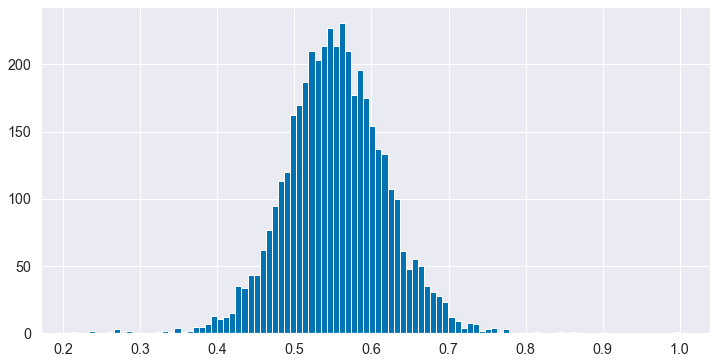

In [41]:
_, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.hist(adaptation_ix, bins=100);

In [42]:
matching_df = trna_ai[
    trna_ai['protein'].isin(np.unique([t[0] for t in original_proteins_562]))
]
adaptation_ix_top_codon = matching_df['adaptation_index'].values

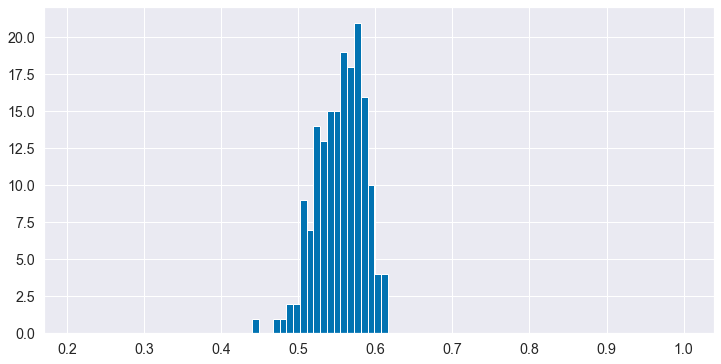

In [43]:
_, ax2 = plt.subplots(1, 1, figsize=(12, 6))
ax2.hist(adaptation_ix_top_codon, bins=20);
ax2.set_xlim(ax.get_xlim());

In [44]:
matching_df[['protein', 'adaptation_index']]

,protein,adaptation_index
677,ClpB chaperone,0.616203
720,malate synthase A,0.613474
817,peptidoglycan DD-transpeptidase MrdA,0.607896
819,tail-specific protease,0.607810
828,copper-containing amine oxidase,0.607257
...,...,...
3616,putative transporter YdhK,0.493055
3723,"fused putative oxidoreductase, Fe-S subunit an...",0.486201
3856,exodeoxyribonuclease V subunit RecD,0.476493
3878,DNA-binding transcriptional activator HyfR,0.474149


## Compute mean diff 

In [45]:
def compute_adaptation_mean_diff(assembly_accessions):
    cached_proteins = {}
    
    diff = []
    for i, assembly_accession in enumerate(assembly_accessions):
        if (i+1) % 100 == 0:
            print(f'{i+1:,} / {len(assembly_accessions):,}')
        
        trna_ai_path = os.path.join(os.getcwd(), f'data/trn_adaptation_index/{assembly_accession}_tai.csv')
        trna_ai = pd.read_csv(trna_ai_path)
        
        species_taxid = trna_ai['species_taxid'].iloc[0]
    
        if species_taxid in cached_proteins:
            proteins = cached_proteins[species_taxid]
        else:
            proteins = retrieve_orginal_proteins(
                graph,
                species_taxid=species_taxid,
                include_neighbours=False,
            )
            cached_proteins[species_taxid] = proteins
            
        mean_1 = trna_ai['adaptation_index'].mean()
        mean_2 = trna_ai[
            trna_ai['protein'].isin(np.unique([t[0] for t in proteins]))
        ]['adaptation_index'].mean()
        
        if pd.isnull(mean_1) or pd.isnull(mean_2):
            print(species_taxid, assembly_accession, mean_1, mean_2)
            continue
        
        diff.append(mean_2 - mean_1)
        
    return np.mean(diff), np.std(diff), np.min(diff), np.max(diff)

In [46]:
q = """
select assembly_accession, species_taxid from assembly_source
"""
response_df = pd.read_sql(q, engine)
assembly_accessions = response_df['assembly_accession'].values

In [47]:
%%time
mean, std, min_, max_ = compute_adaptation_mean_diff(assembly_accessions)
mean, std, min_, max_

100 / 3,282
200 / 3,282
680 GCA_000017705.1 0.6611196531617023 nan
300 / 3,282
400 / 3,282
500 / 3,282
600 / 3,282
700 / 3,282
800 / 3,282
900 / 3,282
1,000 / 3,282
1,100 / 3,282
1,200 / 3,282
1,300 / 3,282
1,400 / 3,282
1,500 / 3,282
1,600 / 3,282
1,700 / 3,282
1,800 / 3,282
1,900 / 3,282
2,000 / 3,282
2,100 / 3,282
2,200 / 3,282
2,300 / 3,282
2,400 / 3,282
2,500 / 3,282
2,600 / 3,282
2,700 / 3,282
2,800 / 3,282
2,900 / 3,282
3,000 / 3,282
3,100 / 3,282
3,200 / 3,282
CPU times: user 5min 37s, sys: 22.4 s, total: 5min 59s
Wall time: 6min 8s


(-0.004329882242986181,
 0.008983127220666189,
 -0.058914431101381504,
 0.030915092541605182)

In [48]:
def compute_mean_adaptation_per_species(assembly_accessions):
    cached_proteins = {}
    
    res = collections.defaultdict(list)
    for i, assembly_accession in enumerate(assembly_accessions):
        if (i+1) % 100 == 0:
            print(f'{i+1:,} / {len(assembly_accessions):,}')
        
        trna_ai_path = os.path.join(os.getcwd(), f'data/trn_adaptation_index/{assembly_accession}_tai.csv')
        trna_ai = pd.read_csv(trna_ai_path)
        
        species_taxid = trna_ai['species_taxid'].iloc[0]
    
        if species_taxid in cached_proteins:
            proteins = cached_proteins[species_taxid]
        else:
            proteins = retrieve_orginal_proteins(
                graph,
                species_taxid=species_taxid,
                include_neighbours=False,
            )
            cached_proteins[species_taxid] = proteins
            
        mean = trna_ai['adaptation_index'].mean()
        res[species_taxid].append(mean)
        
    output = {}
    for key in sorted(res.keys()):
        output[key] = np.mean([m for m in res[key] if not pd.isnull(m)])
        
    return output

In [51]:
%%time
mean_adaptation_per_species = compute_mean_adaptation_per_species(assembly_accessions)

100 / 3,282
200 / 3,282
300 / 3,282
400 / 3,282
500 / 3,282
600 / 3,282
700 / 3,282
800 / 3,282
900 / 3,282
1,000 / 3,282
1,100 / 3,282
1,200 / 3,282
1,300 / 3,282
1,400 / 3,282
1,500 / 3,282
1,600 / 3,282
1,700 / 3,282
1,800 / 3,282
1,900 / 3,282
2,000 / 3,282
2,100 / 3,282
2,200 / 3,282
2,300 / 3,282
2,400 / 3,282
2,500 / 3,282
2,600 / 3,282
2,700 / 3,282
2,800 / 3,282
2,900 / 3,282
3,000 / 3,282
3,100 / 3,282
3,200 / 3,282
CPU times: user 5min 53s, sys: 24 s, total: 6min 17s
Wall time: 6min 26s


0.7526456316462177


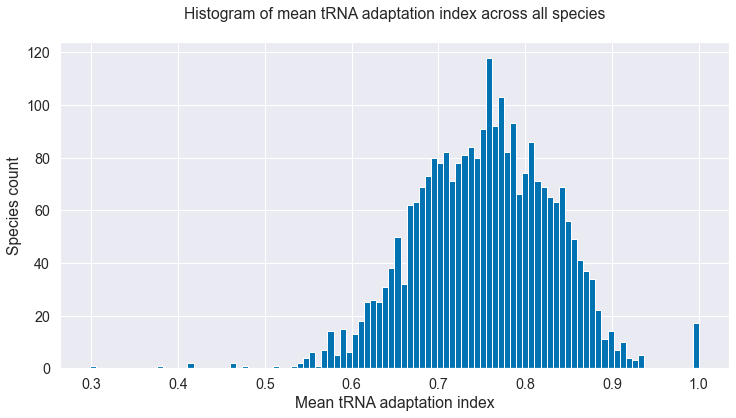

In [52]:
_, ax3 = plt.subplots(1, 1, figsize=(12, 6))
ax3.hist(list(mean_adaptation_per_species.values()), bins=100);
print(np.mean(list(mean_adaptation_per_species.values())))
ax3.set_title('Histogram of mean tRNA adaptation index across all species\n');
ax3.set_xlabel('Mean tRNA adaptation index');
ax3.set_ylabel('Species count');

## Does length have an effect on genes close to the mean?

In [53]:
def compute_distributions_of_length(assembly_accessions):
    cds_codon_bias_folder = os.path.join(os.getcwd(), 'data/cds_codon_bias/')
    
    lengths_all = []
    lengths_below = []
    for i, assembly_accession in enumerate(assembly_accessions):
        if (i+1) % 200 == 0:
            print(f'{i+1} / {len(assembly_accessions)}')
        
        path_all = os.path.join(cds_codon_bias_folder, f'all/{assembly_accession}_codon_bias.csv')
        path_below = os.path.join(cds_codon_bias_folder, f'below_threshold/{assembly_accession}_codon_bias.csv')
        
        df_all = pd.read_csv(path_all)
        df_below = pd.read_csv(path_below)
        
        lengths_all.extend(df_all['length'].values.tolist())
        lengths_below.extend(df_below['length'].values.tolist())
        
    return np.array(lengths_all), np.array(lengths_below)

In [54]:
%%time
lengths_all, lengths_below = compute_distributions_of_length(assembly_accessions)

200 / 3282
400 / 3282
600 / 3282
800 / 3282
1000 / 3282
1200 / 3282
1400 / 3282
1600 / 3282
1800 / 3282
2000 / 3282
2200 / 3282
2400 / 3282
2600 / 3282
2800 / 3282
3000 / 3282
3200 / 3282
CPU times: user 2min 8s, sys: 17.3 s, total: 2min 25s
Wall time: 2min 30s


In [55]:
def plot_distributions(lengths_all, lengths_below):
    palette = sns.color_palette()
    _, axes = plt.subplots(1, 2, figsize=(20, 6))
    
    ax1 = axes[0]
    ax2 = axes[1]
    
    ax1.hist(lengths_all, bins=100, log=True)
    ax1.set_title('Length distribution (all)')
    xlim = ax1.get_xlim()
    
    ax2.hist(lengths_below, bins=100, color=palette[1], log=True)
    ax2.set_title('Length distribution (below threshold)')
    ax2.set_xlim(xlim)
    
    return ax1, ax2

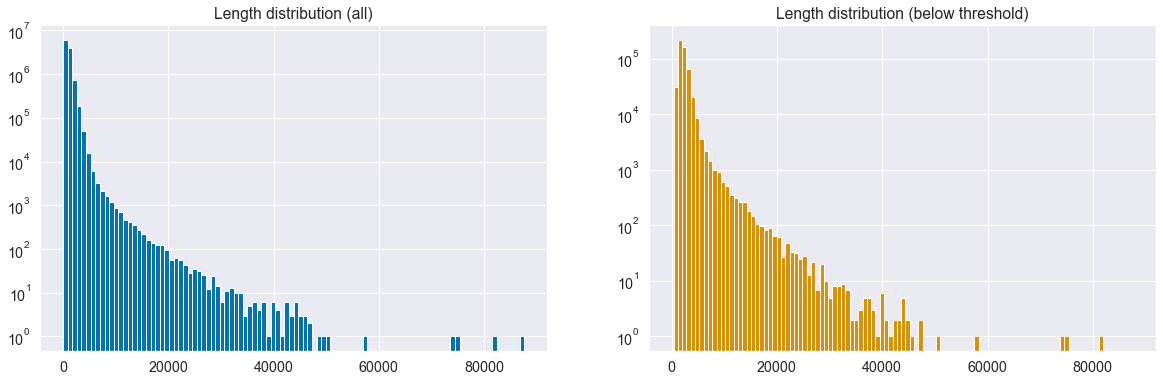

In [56]:
plot_distributions(lengths_all, lengths_below);

## Distance to perfectly balanced

In [57]:
distance_matrix_path = os.path.join(os.getcwd(), 'data/distance_matrix.npy')
distance_matrix = np.load(distance_matrix_path, allow_pickle=True)

In [58]:
species_codon_df[ratio_columns]

,AAA_ratio,AAG_ratio,AAT_ratio,AAC_ratio,ACT_ratio,ACC_ratio,ACA_ratio,ACG_ratio,CGT_ratio,CGC_ratio,...,GTG_ratio,TAA_ratio,TAG_ratio,TGA_ratio,TAC_ratio,TAT_ratio,TGC_ratio,TGT_ratio,TTC_ratio,TTT_ratio
species_taxid,,,,,,,,,,,,,,,,,,,,,
7,0.082550,0.917450,0.327724,0.672276,0.024511,0.575353,0.036262,0.363875,0.078732,0.615278,...,0.603462,0.059996,0.093068,0.846937,0.387338,0.612662,0.903673,0.096327,0.897180,0.102820
9,0.919627,0.080373,0.858168,0.141832,0.454569,0.050026,0.446018,0.049387,0.325065,0.043907,...,0.064608,0.790826,0.100917,0.108257,0.130608,0.869392,0.176688,0.823312,0.080224,0.919776
11,0.007302,0.992698,0.010730,0.989270,0.008586,0.425527,0.015789,0.550098,0.092597,0.559134,...,0.480311,0.009482,0.085967,0.904551,0.981660,0.018340,0.966107,0.033893,0.994594,0.005406
14,0.664866,0.335134,0.775571,0.224429,0.458203,0.188052,0.304183,0.049563,0.035122,0.008361,...,0.153708,0.563059,0.206130,0.230811,0.208150,0.791850,0.204657,0.795343,0.189441,0.810559
19,0.551810,0.448190,0.440559,0.559441,0.099134,0.591478,0.097796,0.211592,0.204394,0.366337,...,0.334484,0.340503,0.164193,0.495304,0.486740,0.513260,0.636140,0.363860,0.502549,0.497451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1813871,0.772490,0.227510,0.681741,0.318259,0.240711,0.192149,0.446839,0.120302,0.243327,0.187369,...,0.205557,0.680140,0.164518,0.155342,0.300637,0.699363,0.476391,0.523609,0.250815,0.749185
1833852,0.589533,0.410467,0.567693,0.432307,0.202326,0.538744,0.183109,0.075821,0.195981,0.173208,...,0.343317,0.582863,0.286616,0.130521,0.346503,0.653497,0.459139,0.540861,0.237507,0.762493
1835254,0.555758,0.444242,0.685138,0.314862,0.374892,0.272930,0.209890,0.142287,0.341983,0.323291,...,0.254571,0.660029,0.156387,0.183584,0.391660,0.608340,0.547508,0.452492,0.294507,0.705493


In [59]:
def make_uniform_bias(codon_to_aa_table, aa_to_codons, ratio_columns):
    uniform_bias = np.zeros((len(ratio_columns),))
    for i, col in enumerate(ratio_columns):
        codon = col.replace('_ratio', '')
        aa = codon_to_aa_table[codon]
        synonyms = aa_to_codons[aa]
        
        uniform_bias[i] = 1 / len(synonyms)
        
    return uniform_bias

In [60]:
uniform_bias = make_uniform_bias(codon_to_aa_table, aa_to_codons, ratio_columns)
uniform_bias

array([0.5       , 0.5       , 0.5       , 0.5       , 0.25      ,
       0.25      , 0.25      , 0.25      , 0.16666667, 0.16666667,
       0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.33333333, 0.33333333, 0.33333333, 0.5       , 0.5       ,
       0.5       , 0.5       , 0.25      , 0.25      , 0.25      ,
       0.25      , 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667, 0.16666667, 0.5       , 0.5       , 0.5       ,
       0.5       , 0.25      , 0.25      , 0.25      , 0.25      ,
       0.25      , 0.25      , 0.25      , 0.25      , 0.25      ,
       0.25      , 0.25      , 0.25      , 0.33333333, 0.33333333,
       0.33333333, 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       ])

In [61]:
def compute_distance_to_uniform_bias(species_codon_df, uniform_bias, ratio_columns):
    X = species_codon_df[ratio_columns].values
    return compute_codon_bias_distance(X, uniform_bias)

In [62]:
distance_to_uniform = compute_distance_to_uniform_bias(species_codon_df, uniform_bias, ratio_columns)
species_codon_df['uniform_dist'] = distance_to_uniform

2020-12-04 12:34:41,529 (WARNING) *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


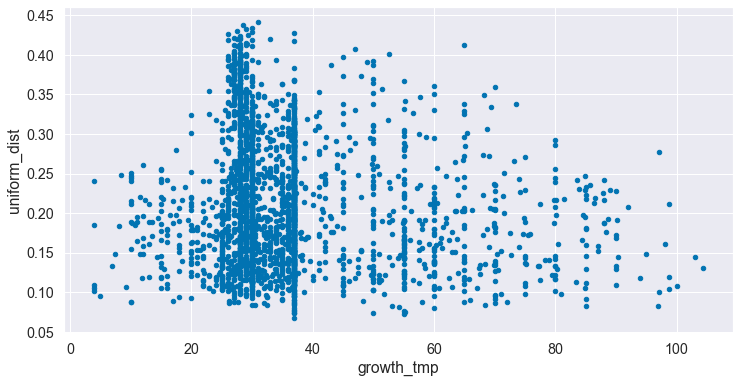

In [63]:
species_codon_df.plot.scatter(
    x='growth_tmp',
    y='uniform_dist',
    figsize=(12, 6),
);

In [64]:
species_codon_df.loc[[562, 2336]][['uniform_dist']]

,uniform_dist
species_taxid,
562,0.145268
2336,0.133543
